# An Analysis of Wind Speeds in the North Sea

---

### Data

We will be working with [data](https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/) collected by [DWD](https://dwd.de) on Helgoland in a 10-minute intervall from 1996 to 2022. For loading the data, we have to manually collect the from a http server.


### Imports and Usage

You can simply use the `environment.yml` file to create a new conda environment with all the needed packages by running `conda env create -f environment.yml`. The only relevant parameter you may want to change is `RELOAD`. If set to `True`, all the needed data will be downloaded and saved in the `data/` folder.

## Data Loading

In [9]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import requests as rq
import zipfile
from bs4 import BeautifulSoup
import os
import seaborn as sns
import pickle

plt.rcParams['figure.dpi'] = 400

# set true to download the data and unzip into the current directory
RELOAD = False
ZIP_NAME = "data.zip"
DATA_FOLDER = "data"

DATA_BASE_URL = "https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/"
KINDS = ["wind", "air_temperature", "precipitation", "solar"]
METRIC_URLS = [DATA_BASE_URL + postfix + "/historical/" for postfix in KINDS]
print(METRIC_URLS)

['https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/wind/historical/', 'https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/air_temperature/historical/', 'https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/precipitation/historical/', 'https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/solar/historical/']


In [10]:
def download_and_extract(url: str, kind: str, station_id: str = "02115") -> dict:
    response = rq.get(url)
    soup = BeautifulSoup(response.text, "html.parser")

    # find dataset desciption (pdf)
    descr_resp = rq.get(f"{DATA_BASE_URL}/{kind}")
    descr_soup = BeautifulSoup(descr_resp.text, "html.parser")
    descriptions = [a.get("href") for a in descr_soup.find_all("a", href=True) if a.get("href").__contains__("pdf")]
    descrs_resps = list(map(lambda desc: rq.get(f"{DATA_BASE_URL}/{kind}/{desc}"), descriptions))

    # Extract all links with data of the appropiate station
    links = [a.get("href") for a in soup.find_all('a', href=True) if a.get("href").__contains__(station_id)]
    print(f"Found links: {links}")

    responses = [rq.get(url + file) for file in links]

    # check if we need to create folders
    save_path = os.path.join("data", kind)
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    
    # save dataset description pdfs
    for descr, resp in zip(descriptions, descrs_resps):
        with open(os.path.join(save_path, descr), "wb") as file:
            file.write(resp.content)

    # for each matching response download the zip and extract it
    files = [] # remember file names of the extracted zip files
    for i, r in enumerate(responses):
        zip_name = os.path.join("data", kind, f"file{i}.zip")
        with open(zip_name, "wb") as z:
            z.write(r.content)

        with zipfile.ZipFile(zip_name, "r") as zip_file:
            for filename in zip_file.namelist():
                files.append(os.path.join(save_path, filename))
            zip_file.extractall(os.path.join("data", kind))

        # we don't need the zip anymore
        os.remove(zip_name)
    
    return files

# have mapping of metric to relevant files for loading into dataframes later on
kind_files = { kind : [] for kind in KINDS }
kind_file_paths = os.path.join("data", "contents.pickle")
if RELOAD:
    for kind, folder in zip(KINDS, METRIC_URLS):
        print(f"{kind}: {folder}")
        files = download_and_extract(folder, kind)
        kind_files[kind] = files

    with open(os.path.join(kind_file_paths), 'wb') as handle:
        pickle.dump(kind_files, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
else:
    with open(kind_file_paths, 'rb') as handle:
        metric_files = pickle.load(handle)
    for kind in KINDS:
        print(f"Files containing {kind} data:\n\t{metric_files[kind]}")

Files containing wind data:
	['data/wind/produkt_zehn_min_ff_19961220_19991231_02115.txt', 'data/wind/produkt_zehn_min_ff_20000101_20091231_02115.txt', 'data/wind/produkt_zehn_min_ff_20100101_20191231_02115.txt', 'data/wind/produkt_zehn_min_ff_20200101_20221231_02115.txt']
Files containing air_temperature data:
	['data/air_temperature/produkt_zehn_min_tu_19961219_19991231_02115.txt', 'data/air_temperature/produkt_zehn_min_tu_20000101_20091231_02115.txt', 'data/air_temperature/produkt_zehn_min_tu_20100101_20191231_02115.txt', 'data/air_temperature/produkt_zehn_min_tu_20200101_20221231_02115.txt']
Files containing precipitation data:
	['data/precipitation/produkt_zehn_min_rr_19961219_19991231_02115.txt', 'data/precipitation/produkt_zehn_min_rr_20000101_20091231_02115.txt', 'data/precipitation/produkt_zehn_min_rr_20100101_20191231_02115.txt', 'data/precipitation/produkt_zehn_min_rr_20200101_20221231_02115.txt']
Files containing solar data:
	['data/solar/produkt_zehn_min_sd_19961219_199912

In [4]:
kind_df = { kind: None for kind in KINDS }
for kind, files in metric_files.items():
    dfs = []
    for file in files:
        df = pd.read_csv(file, sep=";")
        df["MESS_DATUM"] = pd.to_datetime(df["MESS_DATUM"], format="%Y%m%d%H%M")
        dfs.append(df)
    df = pd.concat(dfs)
    df.sort_values(by="MESS_DATUM", inplace=True)
    df.columns = map(lambda c: c if c == "STATIONS_ID" or c == "MESS_DATUM" else f"{c}_{kind}", df.columns)
    print(f"{kind}:\n{df.describe()}")
    kind_df[kind] = df

wind:
       STATIONS_ID                     MESS_DATUM       QN_wind    FF_10_wind  \
count    1348857.0                        1348857  1.348857e+06  1.348857e+06   
mean        2115.0  2010-02-09 21:28:30.455297280  2.267581e+00 -3.537724e+01   
min         2115.0            1996-12-19 10:40:00  1.000000e+00 -9.990000e+02   
25%         2115.0            2003-09-13 20:10:00  1.000000e+00  4.800000e+00   
50%         2115.0            2010-02-13 02:20:00  3.000000e+00  7.400000e+00   
75%         2115.0            2016-07-12 20:40:00  3.000000e+00  1.030000e+01   
max         2115.0            2022-12-31 23:50:00  3.000000e+00  5.180000e+01   
std            0.0                            NaN  9.586172e-01  2.046541e+02   

         DD_10_wind  
count  1.348857e+06  
mean   1.529980e+02  
min   -9.990000e+02  
25%    1.200000e+02  
50%    2.100000e+02  
75%    2.800000e+02  
max    3.600000e+02  
std    2.606936e+02  
air_temperature:
       STATIONS_ID                     MESS_DATUM

In [13]:
dfs = list(kind_df.values())
df = pd.merge(dfs[0], dfs[1], on=["MESS_DATUM", "STATIONS_ID"], how="inner", suffixes=tuple(list(map(lambda x: "_" + x, kind_df.keys()))[:2]))

# Loop through the remaining DataFrames and merge with the result
for i, df1 in enumerate(dfs[2:]):
    df = pd.merge(df, df1, on=["MESS_DATUM", "STATIONS_ID"], how="inner", suffixes=(None, "_" + list(kind_df.keys())[i+2]))

# Display the result
df

,STATIONS_ID,MESS_DATUM,QN_wind,FF_10_wind,DD_10_wind,eor_wind,QN_air_temperature,PP_10_air_temperature,TT_10_air_temperature,TM5_10_air_temperature,...,RWS_IND_10_precipitation,QN_precipitation,eor_precipitation,QN_solar,DS_10_solar,GS_10_solar,SD_10_solar,LS_10_solar,QN_solar,eor_solar
0,2115,1996-12-19 10:40:00,1,15.8,70,eor,1.0,1008.2,2.0,1.9,...,0,NaN,NaN,1.0,-999.0,-999.0,0.0,-999,NaN,NaN
1,2115,1996-12-19 10:50:00,1,16.2,70,eor,1.0,1008.1,2.0,1.9,...,0,NaN,NaN,1.0,-999.0,-999.0,0.0,-999,NaN,NaN
2,2115,1996-12-19 11:00:00,1,16.6,70,eor,1.0,1008.1,2.1,2.1,...,0,NaN,NaN,1.0,-999.0,-999.0,0.0,-999,NaN,NaN
3,2115,1996-12-19 11:10:00,1,16.0,80,eor,1.0,1008.1,2.3,2.2,...,0,NaN,NaN,1.0,-999.0,-999.0,0.0,-999,NaN,NaN
4,2115,1996-12-19 11:20:00,1,16.3,70,eor,1.0,1008.0,2.1,2.0,...,0,NaN,NaN,1.0,-999.0,-999.0,0.0,-999,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1348936,2115,2022-12-31 23:10:00,3,13.6,230,eor,NaN,1000.6,11.1,10.3,...,0,3.0,eor,NaN,0.0,0.0,0.0,-999,3.0,eor
1348937,2115,2022-12-31 23:20:00,3,12.4,230,eor,NaN,1000.6,10.9,10.2,...,0,3.0,eor,NaN,0.0,0.0,0.0,-999,3.0,eor
1348938,2115,2022-12-31 23:30:00,3,12.6,230,eor,NaN,1000.5,11.1,10.3,...,0,3.0,eor,NaN,0.0,0.0,0.0,-999,3.0,eor
1348939,2115,2022-12-31 23:40:00,3,12.6,230,eor,NaN,1000.6,11.2,10.4,...,0,3.0,eor,NaN,0.0,0.0,0.0,-999,3.0,eor


## Explorative Data Analysis

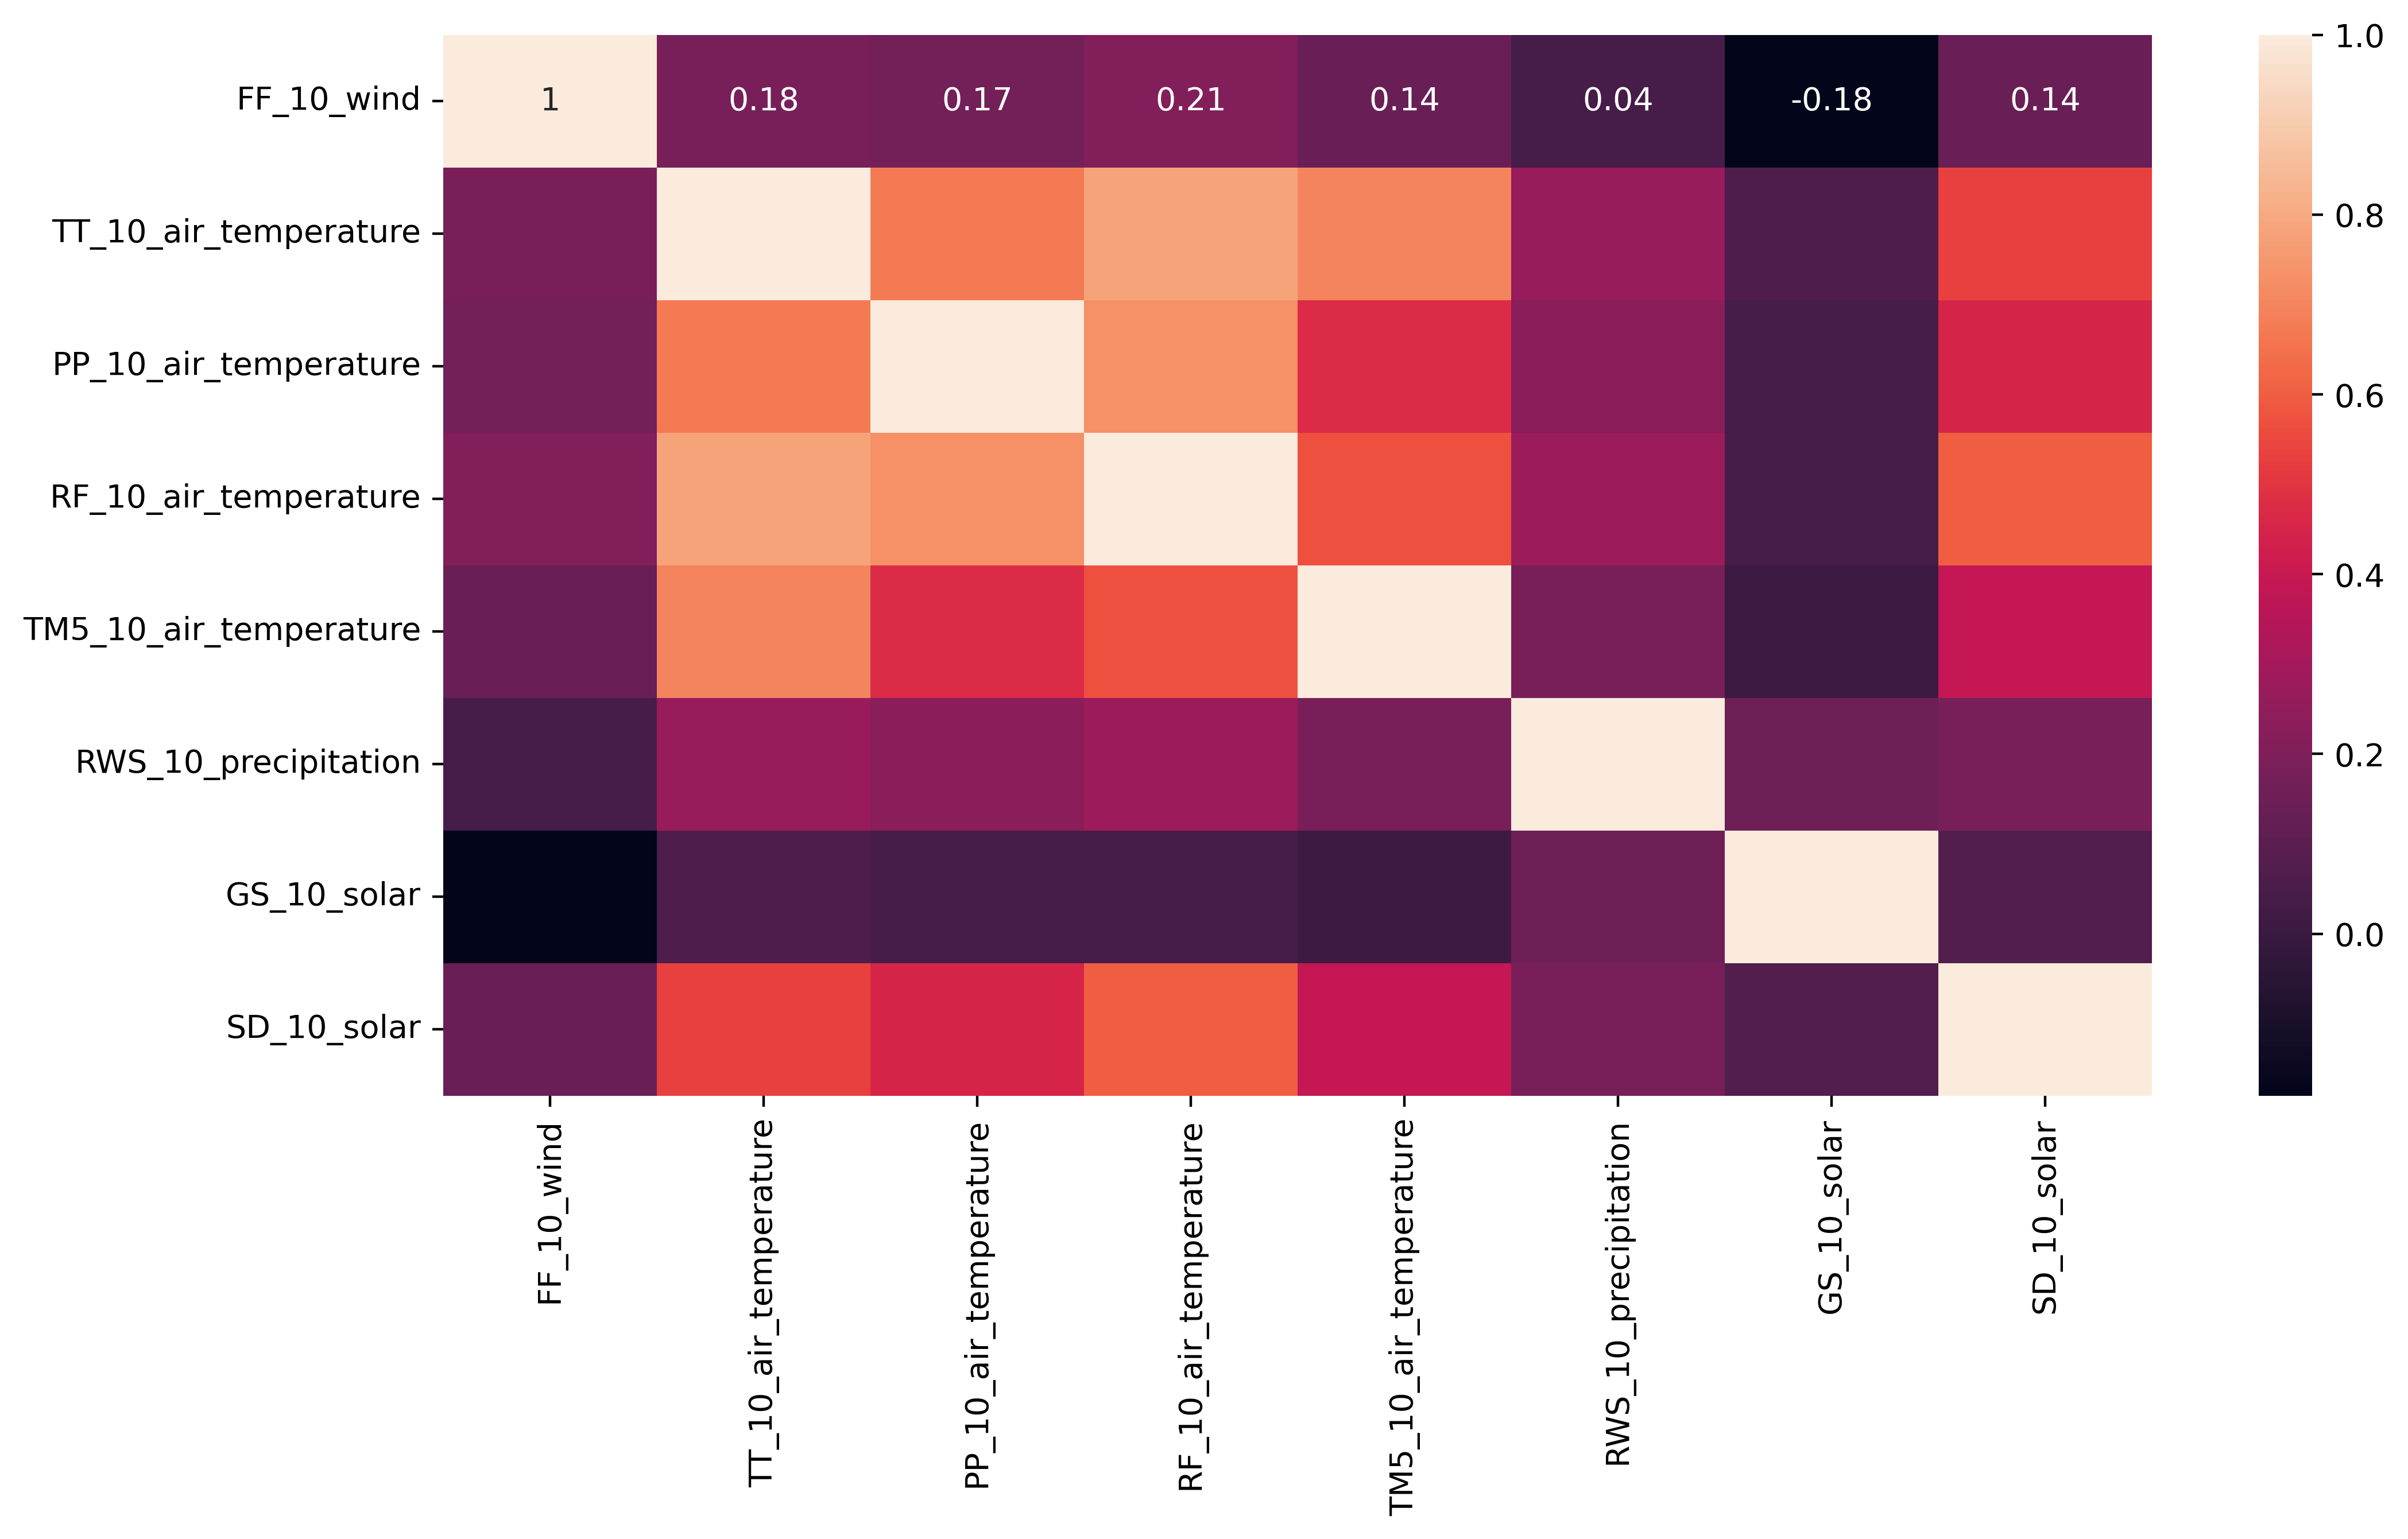

In [36]:
_ = plt.figure(figsize=(12, 6))
corr = df[["FF_10_wind", "TT_10_air_temperature", "PP_10_air_temperature", "RF_10_air_temperature", "TM5_10_air_temperature", "RWS_10_precipitation", "GS_10_solar", "SD_10_solar"]].corr().round(2)
sns.heatmap(corr, annot=True)
plt.show()